In [32]:
!pip install fake_useragent

  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-cp36-none-any.whl size=13485 sha256=6dfe2506aed3f350a70761f0eb86063d035a2f5887f264a7f892e2ed72e4644f
  Stored in directory: /root/.cache/pip/wheels/5e/63/09/d1dc15179f175357d3f5c00cbffbac37f9e8690d80545143ff
Successfully built fake-useragent


In [33]:
import sqlite3
import requests
import re
from fake_useragent import UserAgent
from bs4 import BeautifulSoup
import time
import random
import json
from collections import Counter

In [2]:
def safe_request(url):
    try:
        html = session.get(url, headers={'User-Agent': ua.random}, verify=False).text
    except Exception as e:
        with open('exceptions.txt', 'a', encoding='utf-8') as f:
            f.write(str(e.__class__) + '\n' + url + '\n')
        html = ''
    return html

In [3]:
def find_links(html):
    soup = BeautifulSoup(html,'html.parser')
    urls = soup.find_all('a', {'class': 'news_title'})
    urls = [url.get('href') for url in urls]
    return urls

In [4]:
def get_info(html):
    soup = BeautifulSoup(html,'html.parser')
    
    title = soup.find('h1',{'id':'news-title'})
    date = soup.find('div', {'class': 'date'}).get_text()
    text = soup.find('div',{'class':'news-text'}).get_text()
    try:
        tags = [a.get_text() for a in soup.find('div',{'class':'news-tags'}).find_all('a')]
    except AttributeError:
        tags = []
    try:
        rubric = soup.find('span',{'class':'rubric'}).find('a').get_text()
    except AttributeError:
        rubric = ''
    return {
        'title':title,
        'date': date,
        'text': text,
        'tags': tags,
        'rubric': rubric
    }

In [5]:
def crawl(url_root, n=1000):
    articles = {}
    page = 1
    while len(articles) <= n:
        url = url_root + '?p=' + str(page)
        html = safe_request(url)
        links = find_links(html)
        for link in tqdm(links):
            item_id = link.split('/')[-2]
            if item_id not in articles:
                html = safe_request(link)
                data = get_info(html)
                articles[item_id] = data
                time.sleep(random.uniform(1, 4))
        page += 1
    return articles

In [34]:
url_main = 'https://www.marimedia.ru/news/'
ua = UserAgent(verify_ssl=False)
session = requests.session()

In [ ]:
articles = crawl(url_main)

In [ ]:
articles_df.to_csv('articles.csv')

In [18]:
articles_df = pd.read_csv('articles.csv',index_col=[0])

### Лемматизация

In [ ]:
import pymorphy2
from string import punctuation
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")

def preprocess(text):
    morph = pymorphy2.MorphAnalyzer()
    tokens = nltk.tokenize.word_tokenize(text.lower())
    tokens = [morph.parse(word)[0].normal_form for word in tokens if word not in russian_stopwords\
              and word != " " \
              and word.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
tqdm.pandas()
articles_df['lemmatized'] = articles_df.text.progress_apply(preprocess)

In [55]:
tags_df = articles_df.tags.explode()
articles_df.drop(columns=['tags'],inplace=True)

### Сохраняем в базу данных

Так как все уже лежит в датафрейме, то можно просто его сохранить сразу

In [56]:
import sqlite3

In [57]:
con = sqlite3.connect('news.db')
c = con.cursor()

In [58]:
import pandas.io.sql as pd_sql

In [60]:
pd_sql.to_sql(articles_df, "articles", con, if_exists='replace')
pd_sql.to_sql(tags_df, "tags", con, if_exists='replace')

In [61]:
con.commit()
con.close()

### Анализ

In [62]:
!pip install wordcloud

In [63]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
articles_df.rubric.unique()

array(['Культура', 'Общество', 'Туризм', 'Происшествия', 'Коронавирус',
       'ЖКХ', 'Транспорт', 'Религия', 'ПФО', 'Экология', 'Политика',
       'Антикризис 2020', 'Нацпроекты', 'Экономика',
       'Наука и Образование', 'Спорт', 'Не проходите мимо!', 'Погода',
       'Бизнес', 'Медицина', 'Россия', 'Великая Победа', 'Йошкар-Ола',
       'Сельское хозяйство', 'Новости портала'], dtype=object)

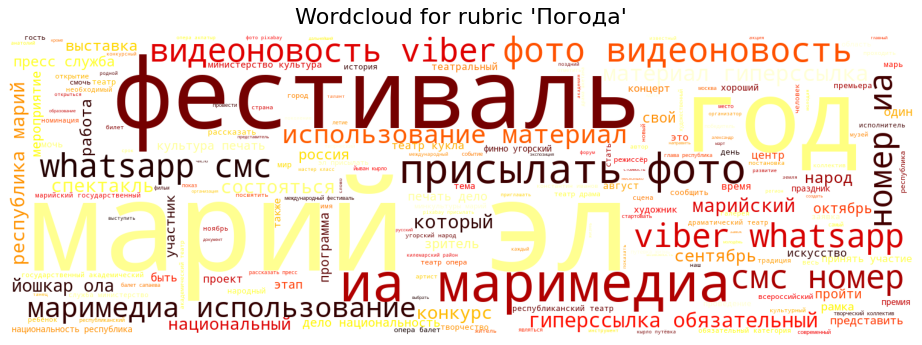

In [79]:
text = ' '.join(articles_df.lemmatized[articles_df.rubric == 'Культура'].to_list())

wordcloud = WordCloud(
    background_color ='white',
    width = 1500,
    height = 500, 
    colormap='hot'
).generate(text)

plt.figure(figsize = (15, 5), dpi=80) 
plt.imshow(wordcloud)
plt.axis("off") 
plt.title("Wordcloud for rubric 'Погода'", fontsize=20, pad=10)
plt.show()

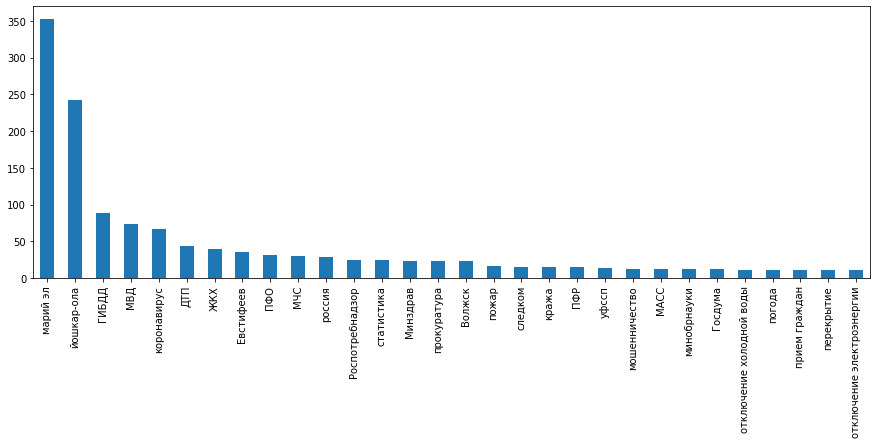

In [82]:
plt.figure(figsize=(15,5))
mask = tags_df.value_counts() > 10
tags_df.value_counts()[mask].sort_values(ascending=False).plot(kind='bar')